In [604]:
#python normal imports
from pydantic import BaseModel,Field
import os
from dotenv import load_dotenv
from typing import Annotated,TypedDict


In [605]:
#AI import for langchain and lang graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
import requests
#other imports
from IPython.display import Image, display
import gradio as gr


In [606]:
class State(BaseModel):
    messages : Annotated[list,add_messages]
    

In [607]:
load_dotenv(override=True)

True

In [608]:
google_api_key = os.getenv("GEMINI_API_KEY")
google_model = "gemini-2.0-flash"

In [609]:
llm = ChatGoogleGenerativeAI(api_key=google_api_key,model=google_model)
serper = GoogleSerperAPIWrapper()

In [610]:
search_tool = Tool(
    name="search_tool",
    func= serper.run,
    description="this tool is for search google"
)

In [611]:
search_tool

Tool(name='search_tool', description='this tool is for search google', func=<bound method GoogleSerperAPIWrapper.run of GoogleSerperAPIWrapper(k=10, gl='us', hl='en', type='search', result_key_for_type={'news': 'news', 'places': 'places', 'images': 'images', 'search': 'organic'}, tbs=None, serper_api_key='35dbea66013afdf0121d0e8c6d38272ac9b80a56', aiosession=None)>)

In [612]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [613]:
puch_tool = Tool(
    name="push_tool",
    func=push,
    description="used for push notification"
)

In [614]:
#puch_tool.invoke("hello")

In [615]:
new_tools=[search_tool,puch_tool]
llm_with_tool = llm.bind_tools(tools=new_tools)
graph_builder = StateGraph(State)

In [ ]:

def chatbot(old_state:State) -> State:
    print(old_state.messages)
    #return {"messages": [llm_with_tool.invoke(old_state.messages)]}
    response =  llm_with_tool.invoke(old_state["messages"])
    print(response)
    return State(messages=[response])

In [617]:
from langgraph.prebuilt import ToolNode,tools_condition
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=new_tools))

In [618]:
graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")


In [619]:

graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")


In [620]:
graph = graph_builder.compile()

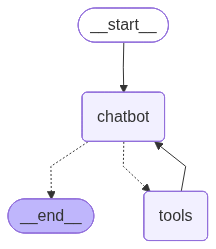

In [621]:
try:
    png_bytes = graph.get_graph().draw_mermaid_png()
    display(Image(data=png_bytes))
except Exception as e:
    print("⚠️ Could not render PNG. Showing Mermaid text only.")
    print("Error:", e)


In [622]:
def chat(user_input:str,history):
    intial_state = State(messages=[{"role":"user","content":user_input}])
    result = graph.invoke(intial_state)
    print(result)
    return result['messages'][-1].content
    

In [ ]:
gr.ChatInterface(chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7903
* To create a public link, set `share=True` in `launch()`.


[HumanMessage(content='sent notofication todays weather', additional_kwargs={}, response_metadata={}, id='a5e08dd6-f261-44b6-9f58-cd88f922e6f2')]
[HumanMessage(content='sent notofication todays weather', additional_kwargs={}, response_metadata={}, id='a5e08dd6-f261-44b6-9f58-cd88f922e6f2'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'push_tool', 'arguments': '{"__arg1": "todays weather"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--1a639876-05f9-402a-b1e1-dabbae09b251-0', tool_calls=[{'name': 'push_tool', 'args': {'__arg1': 'todays weather'}, 'id': '8349e4e6-7bce-4290-b302-ab8c448f50fd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 37, 'output_tokens': 9, 'total_tokens': 46, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='null', name='push_tool', id='d05e9a40-f8f6-4176-8c17-8f767eec4f7c', tool_call_id='8349e4e6-7bce-4290-b302-ab8c448f50fd')